# Estimate specific surface using grain size distribution statistics

Loads grains size statistics (mean, stdev) from a .csv file, generate grain size distribution and calculate specific surface following eq. 2 in Luijendijk and Gleeson (2015, Geofluids 15, or Crustal permeability book chapter 2016) ([link](https://onlinelibrary.wiley.com/doi/full/10.1111/gfl.12115)).

and example csv file that contains grain size data from a borehole in the southern netherlands is located in the subdirectory data [here](data/porperm_data_well_AST02.csv).

Note that by default this notebook calculate the specific surface of the granular fraction only using truncated normal or log-normal distributions where grains that are smaller than 2 micron are discarded.

## Import Python modules


In [35]:
import math
import os
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as pl

## Some important variables:

In [36]:
# name of file with grain size distribution data
filename = 'data/example_dataset_seafloor_sediments.csv'

# density of the solid matrix of the sediment
rho_s = 2650.0

# cutoff for distinguishing clay and non-clay / granular sediments (m)
# the default value is 2.0 micron, but higher values are also sometimes used
clay_cutoff = 4.0e-6

# normal or log-normal grain size distribution
log_transform = False

# column names for mean, stdev grain size:
gs_mean_column = 'grain_size_mean'
gs_std_column = 'grain_size_stdev'

## Set up a function to calculate specific surface

In [37]:
def calculate_specific_surface_discrete(grain_size, freq, rho_s):
    
    """
    calculate specific surface
    eq. ... in 
    """
    
    ss = 6.0 / rho_s * (freq / grain_size).sum()
    
    return ss

## Function to generate distributions

In [38]:
def generate_gs_distributions(gs_mean, gs_std,
                              rho_s=2650.0, 
                              clay_cutoff=2.0e-6,
                              log_transform=True):
    """
    calculate specific surface for granular fraction (ie. > 2 um)
    input: grainsize distribution, mean log10(grainsize), std log10(grainsize)

    """
    
    # grain size bins
    if log_transform is True:
        gs_sim = np.arange(-7.0, -1, 0.01)
    else:
        gs_sim = 10**np.arange(-7.0, -1, 0.01)
        
    # calculate cdf
    cdf_gs = scipy.stats.norm.cdf(gs_sim, gs_mean, gs_std)
    
    # convert to frequency for each bin
    freq_gs = cdf_gs.copy()
    freq_gs[1:] = (cdf_gs[1:] - cdf_gs[:-1])
    
    # convert grainsize to real units
    if log_transform is True:
        bins_gs = (10**gs_sim).copy()
    else:
        bins_gs = gs_sim

    # take middle of bin
    bins_gs[1:] = (bins_gs[1:] + bins_gs[:-1]) / 2.0
    
    # remove clay fraction
    freq_gs[bins_gs < 2e-6] = 0
    
    return bins_gs, freq_gs

## load grain size data

In [39]:
df = pd.read_csv(filename)

## generate grain size distributions

In [40]:
gs_freq_all = []
for ix in df.index:
    bins_gs, freq_gs = generate_gs_distributions(df.loc[ix, gs_mean_column], 
                                                 df.loc[ix, gs_std_column],
                                                 rho_s=rho_s, 
                                                 clay_cutoff=clay_cutoff,
                                                 log_transform=log_transform)
    gs_freq_all.append(freq_gs)
    
    df.loc[ix, 'specific_surface_granular_fraction'] = \
        calculate_specific_surface_discrete(bins_gs, freq_gs, rho_s)
 

## Save modified csv file with calculated grain sizes:

In [41]:
fn_out = filename[:-4] + '_with_spec_surf.csv'
print('saving new csv file inlcuding grain size distribution stats and calculated specific surface to ', fn_out)
df.to_csv(fn_out)

saving new csv file inlcuding grain size distribution stats and calculated specific surface to  data/example_dataset_seafloor_sediments_with_spec_surf.csv


In [42]:
df.head()

,sample,clay_fraction,porosity,permeability_measured,kaolinite_fraction,illite_fraction,smectite_fraction,grain_size_mean,grain_size_stdev,specific_surface_granular_fraction
0,"190-1173A-31X-1,135-150",0.86,0.66,2.500000e-17,0.16,0.34,0.43,0.000002,0.000002,377.785799
1,"190-1173A-31X-1,135-150",0.86,0.66,2.400000e-17,0.16,0.34,0.43,0.000002,0.000002,377.785799
2,"190-1173A-31X-1,135-150",0.86,0.66,2.500000e-17,0.16,0.34,0.43,0.000002,0.000002,377.785799
3,"190-1173A-31X-1,135-150",0.86,0.66,4.870000e-17,0.16,0.34,0.43,0.000002,0.000002,377.785799
4,"190-1173A-31X-1,135-150",0.86,0.66,1.800000e-17,0.16,0.34,0.43,0.000002,0.000002,377.785799


## Make a figure with grain size distributions and specific surface

saving figure as  figs/example_dataset_seafloor_sediments_grain_sizes_and_spec_surfaces.png


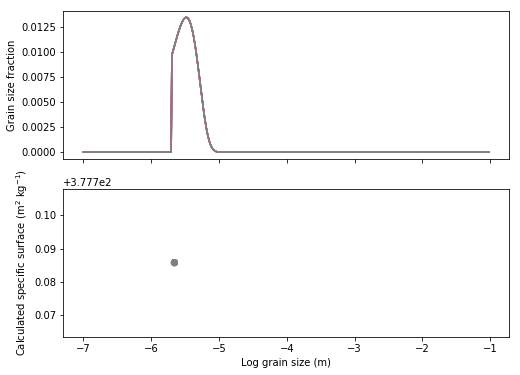

In [43]:
fig, axs = pl.subplots(2, 1, figsize=(8, 6), sharex=True)

# plot grain size distributions:
lines = []
for freq in gs_freq_all:
    l = axs[0].plot(np.log10(bins_gs), freq)
    lines.append(l)
    
colors = [l[-1].get_color() for l in lines]

axs[1].scatter(np.log10(df[gs_mean_column]), df['specific_surface_granular_fraction'], 
               c=colors)

axs[1].set_xlabel('Log grain size (m)')

axs[0].set_ylabel('Grain size fraction')
axs[1].set_ylabel('Calculated specific surface (m$^2$ kg$^{-1}$)')

fn1 = os.path.split(filename)[-1][:-4]
fn2 = fn1 + '_grain_sizes_and_spec_surfaces.png'
fig_fn = os.path.join('figs', fn2)
print('saving figure as ', fig_fn)
fig.savefig(fig_fn)

#axs[0].set_xlabel('Log grain size (m)')

**Fig. caption** *Top panel: grain size distributions, bottom panel: calculated specific surface vs mean grain size*